*Alonso Evan*

*05/05/2020*

This notebook is a direct follow up to this notebook :
* [Home Credit Default Risk PART 2](https://nbviewer.jupyter.org/github/AlonsoEvan/Home-credit-default-risk/blob/master/Home%20Credit%20Default%20Risk%20PART%20ONE.ipynb)

We continue where we left, that is to the part when we aimed to do some manual feature engineering and now we will focus on the automated feature engineering. So let's continue our work !

1. [Import packages](#1)
1. [Functions](#2)
1. [Automated feature engineering](#3)
    - Featuretools Basics
    - Entities and EntitySets
    - Relationships
    - Feature Primitives
    - Deep Feature Synthesis
    - Results
    - Remove Low Importance Features
1. [Feature Selection](#4)
    - Remove Collinear Variables
    - Remove Missing Values
    - Feature Selection through Feature Importances
    - Results
    - More features selection
1. [Hyperparameter Tuning](#5)
    - Hyperparameter Tuning Implementation
    - Grid Search Implementation
    - Random Search Implementation
    - Make Random Forest Predictions using Domain Features
1. [Final submission to Kaggle](#6)
    - Functions and hyperparameters
    - The tuned hyperparameters found with GridSearch
    - The tuned hyperparameters found with RandomSearch
1. [Conclusion](#7)

<a id="1"></a> <br>
## Import packages

In [2]:
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, MinMaxScaler
from sklearn.impute import SimpleImputer

import os

import warnings
warnings.filterwarnings('ignore')


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, cross_validate, train_test_split
import sklearn.model_selection as ms
from lightgbm import LGBMClassifier
import xgboost as xgb

from sklearn.svm import LinearSVC



from sklearn import tree
from sklearn import metrics
from sklearn import ensemble
from sklearn import linear_model 
from sklearn import naive_bayes 

Let's redefine our function used in the previous notebook in order to be clear.

<a id="2"></a> <br>
## Functions

In [25]:
def score(df, cv):
    
    y = df['TARGET']
    X = df.drop(columns = ['SK_ID_CURR', 'TARGET'], axis = 1)
    
    feature_names = list(X.columns)
    
    
    le = LabelEncoder()


    for col in X.columns:
        if X[col].dtypes == 'object':
            if len(list(X[col].unique())) <= 2:
                X[col] = le.fit_transform(X[col])
    
    X = pd.get_dummies(X)
    
    Imputer = SimpleImputer(strategy = 'median')

    X = Imputer.fit_transform(X)

    
    model = LGBMClassifier()
    
    scores = cross_validate(model, X, y, cv = cv, scoring = 'roc_auc', return_train_score = True)
    
   
    return pd.DataFrame(scores)






def features_importance(df):

    y = df['TARGET']
    X = df.drop(columns = ['SK_ID_CURR', 'TARGET'], axis = 1)
    
    
    
    
    le = LabelEncoder()


    for col in X.columns:
        if X[col].dtypes == 'object':
            if len(list(X[col].unique())) <= 2:
                X[col] = le.fit_transform(X[col])
    
    X = pd.get_dummies(X)
    
    feature_names = list(X.columns)
    
    Imputer = SimpleImputer(strategy = 'median')

    X = Imputer.fit_transform(X)

    
    model = LGBMClassifier()
    model1 = model.fit(X, y)
    
    
    feat_importances_values = model1.feature_importances_ 
    
    feat_importances = pd.DataFrame({'feature': feature_names, 'importance': feat_importances_values})
    
    return feat_importances.sort_values(by = 'importance' ,ascending = False)




  
def submission(train, test):
    
    
        y = train['TARGET']
        X_train = train.drop(columns = ['SK_ID_CURR', 'TARGET'], axis = 1)
        X_test = test.drop(columns = ['SK_ID_CURR'], axis = 1)
    
        
    
    
        le = LabelEncoder()


        for col in X_train.columns:
            if X_train[col].dtypes == 'object':
                if len(list(X_train[col].unique())) <= 2:
                    X_train[col] = le.fit_transform(X_train[col])
                    X_test[col] = le.transform(X_test[col])
                    
    
        X_train = pd.get_dummies(X_train)
        X_test = pd.get_dummies(X_test)
        
        X_train, X_test = X_train.align(X_test, join = 'inner', axis = 1)
    
        Imputer = SimpleImputer(strategy = 'median')

        X_train = Imputer.fit_transform(X_train)
        X_test = Imputer.transform(X_test)
    
    
        LGBM = LGBMClassifier().fit(X_train, y)

        # Make predictions on the test data
        predictions = LGBM.predict_proba(X_test)[:, 1]

        LGBM = pd.DataFrame()
        LGBM['SK_ID_CURR'] = test_id
        LGBM['TARGET'] = predictions
        LGBM.to_csv("LGBM.csv", index=False)


<a id="3"></a> <br>
## Automated feature engineering

Now, we will walk through applying automated feature engineering to the Home Credit Default Risk dataset using the featuretools library. Featuretools is an open-source Python package for automatically creating new features from multiple tables of structured, related data. It is ideal tool for problems such as the Home Credit Default Risk competition where there are several related tables that need to be combined into a single dataframe for training (and one for testing).

It's a great alternative, because manual feature engineering can be very tedious. Moreover , manual feature engineering is limited both by human time constraints and imagination: we simply cannot conceive of every possible feature that will be useful. 

The importance of creating the proper features cannot be overstated because a machine learning model can only learn from the data we give to it. Extracting as much information as possible from the available datasets is crucial to creating an effective solution.

Automated feature engineering aims to help the data scientist with the problem of feature creation by automatically building hundreds or thousands of new features from a dataset. Here, we will use Featuretools, the only library for automated feature engineering at the moment.

*Nota Bene : We will work with a subset of the data because this is a computationally intensive*

In [2]:
import featuretools as ft

So let's start all over again and see if automated feature engineering can do better than manual feature engineering.

In [ ]:
# Read in the datasets and limit to the first 1000 rows (sorted by SK_ID_CURR) 
# This allows us to actually see the results in a reasonable amount of time! 
train = pd.read_csv('application_train.csv').sort_values('SK_ID_CURR').reset_index(drop = True).loc[:100000, :]

test = pd.read_csv('application_test.csv').sort_values('SK_ID_CURR').reset_index(drop = True).loc[:100000, :]

bureau = pd.read_csv('bureau.csv').sort_values(['SK_ID_CURR', 'SK_ID_BUREAU']).reset_index(drop = True).loc[:100000, :]

bureau_balance = pd.read_csv('bureau_balance.csv').sort_values('SK_ID_BUREAU').reset_index(drop = True).loc[:100000, :]

cash = pd.read_csv('POS_CASH_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).loc[:100000, :]

credit = pd.read_csv('credit_card_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).loc[:100000, :]

previous = pd.read_csv('previous_application.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).loc[:100000, :]

installments = pd.read_csv('installments_payments.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).loc[:100000, :]

In [4]:
app = train

We'll join the train and test set together but add a separate column identifying the set. This is important because we are going to want to apply the same exact procedures to each dataset. It's safest to just join them together and treat them as a single dataframe.

In [ ]:
# Add identifying column
train['set'] = 'train'
test['set'] = 'test'
test["TARGET"] = np.nan

# Append the dataframes
app = train.append(test, ignore_index = True)

**Featuretools Basics**

Featuretools is an open-source Python library for automatically creating features out of a set of related tables using a technique called deep feature synthesis. Automated feature engineering, like many topics in machine learning, is a complex subject built upon a foundation of simpler ideas.

There are a few concepts that we will cover along the way:

`Entities and EntitySets`

`Relationships between tables`

`Feature primitives: aggregations and transformations`

`Deep feature synthesis`

**Entities and EntitySets**

An entity is simply a table or in Pandas, a dataframe. The observations are in the rows and the features in the columns. An entity in featuretools must have a unique index where none of the elements are duplicated. Currently, only app, bureau, and previous have unique indices (`SK_ID_CURR`, `SK_ID_BUREAU`, and `SK_ID_PREV` respectively)

An EntitySet is a collection of tables and the relationships between them. 

First we'll make an empty entityset named clients to keep track of all the data.

In [5]:
es = ft.EntitySet(id = 'clients')

Now we define each entity, or table of data. We need to pass in an index if the data has one or make_index = True if not.

In [6]:
# Entities with a unique index
es = es.entity_from_dataframe(entity_id = 'app', dataframe = app, index = 'SK_ID_CURR')

es = es.entity_from_dataframe(entity_id = 'bureau', dataframe = bureau, index = 'SK_ID_BUREAU')

es = es.entity_from_dataframe(entity_id = 'previous', dataframe = previous, index = 'SK_ID_PREV')

# Entities that do not have a unique index
es = es.entity_from_dataframe(entity_id = 'bureau_balance', dataframe = bureau_balance, 
                              make_index = True, index = 'bureaubalance_index')

es = es.entity_from_dataframe(entity_id = 'cash', dataframe = cash, 
                              make_index = True, index = 'cash_index')

es = es.entity_from_dataframe(entity_id = 'installments', dataframe = installments,
                              make_index = True, index = 'installments_index')

es = es.entity_from_dataframe(entity_id = 'credit', dataframe = credit,
                              make_index = True, index = 'credit_index')

**Relationships**

Altogether, there are a total of 6 relationships between the tables. Below we specify all six relationships and then add them to the EntitySet.

In [7]:
# Relationship between app and bureau
r_app_bureau = ft.Relationship(es['app']['SK_ID_CURR'], es['bureau']['SK_ID_CURR'])

# Relationship between bureau and bureau balance
r_bureau_balance = ft.Relationship(es['bureau']['SK_ID_BUREAU'], es['bureau_balance']['SK_ID_BUREAU'])

# Relationship between current app and previous apps
r_app_previous = ft.Relationship(es['app']['SK_ID_CURR'], es['previous']['SK_ID_CURR'])

# Relationships between previous apps and cash, installments, and credit
r_previous_cash = ft.Relationship(es['previous']['SK_ID_PREV'], es['cash']['SK_ID_PREV'])
r_previous_installments = ft.Relationship(es['previous']['SK_ID_PREV'], es['installments']['SK_ID_PREV'])
r_previous_credit = ft.Relationship(es['previous']['SK_ID_PREV'], es['credit']['SK_ID_PREV'])

In [8]:
# Add in the defined relationships
es = es.add_relationships([r_app_bureau, r_bureau_balance, r_app_previous,
                           r_previous_cash, r_previous_installments, r_previous_credit])
# Print out the EntitySet
es

Entityset: clients
  Entities:
    app [Rows: 100001, Columns: 122]
    bureau [Rows: 100001, Columns: 17]
    previous [Rows: 100001, Columns: 37]
    bureau_balance [Rows: 100001, Columns: 4]
    cash [Rows: 100001, Columns: 9]
    installments [Rows: 100001, Columns: 9]
    credit [Rows: 100001, Columns: 24]
  Relationships:
    bureau.SK_ID_CURR -> app.SK_ID_CURR
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
    previous.SK_ID_CURR -> app.SK_ID_CURR
    cash.SK_ID_PREV -> previous.SK_ID_PREV
    installments.SK_ID_PREV -> previous.SK_ID_PREV
    credit.SK_ID_PREV -> previous.SK_ID_PREV

*NB* : If we directly link `app` and `cash` via `SK_ID_CURR`; `previous` and `cash` via `SK_ID_PREV`; and `app` and `previous` via `SK_ID_CURR`, then we have created two paths from `app` to `cash`. This results in ambiguity, so the approach we have to take instead is to link `app` to `cash` through `previous`.

**Feature Primitives**

A feature primitive is an operation applied to a table or a set of tables to create a feature. These represent simple calculations, many of which we already use in manual feature engineering

In [9]:
primitives = ft.list_primitives()
pd.options.display.max_colwidth = 100
primitives[primitives['type'] == 'aggregation'].head(10)

,name,type,description
0,trend,aggregation,Calculates the trend of a variable over time.
1,num_unique,aggregation,"Determines the number of distinct values, ignoring `NaN` values."
2,count,aggregation,"Determines the total number of values, excluding `NaN`."
3,min,aggregation,"Calculates the smallest value, ignoring `NaN` values."
4,skew,aggregation,Computes the extent to which a distribution differs from a normal distribution.
5,time_since_first,aggregation,Calculates the time elapsed since the first datetime (in seconds).
6,avg_time_between,aggregation,Computes the average number of seconds between consecutive events.
7,any,aggregation,Determines if any value is 'True' in a list.
8,first,aggregation,Determines the first value in a list.
9,n_most_common,aggregation,Determines the `n` most common elements.


In [10]:
primitives[primitives['type'] == 'transform'].head(10)

,name,type,description
22,subtract_numeric,transform,Element-wise subtraction of two lists.
23,time_since_previous,transform,Compute the time since the previous entry in a list.
24,modulo_numeric_scalar,transform,Return the modulo of each element in the list by a scalar.
25,year,transform,Determines the year value of a datetime.
26,divide_numeric,transform,Element-wise division of two lists.
27,add_numeric_scalar,transform,Add a scalar to each value in the list.
28,diff,transform,Compute the difference between the value in a list and the
29,month,transform,Determines the month value of a datetime.
30,longitude,transform,Returns the second tuple value in a list of LatLong tuples.
31,multiply_numeric_scalar,transform,Multiply each element in the list by a scalar.


**Deep Feature Synthesis**

Deep Feature Synthesis (DFS) is the process featuretools uses to make new features. Because this process is computationally expensive, we can run the function using features_only = True to return only a list of the features and not calculate the features themselves. This can be useful to look at the resulting features before starting an extended computation.

Infortunately, I cannot run this call on the entire dataset, it will took forever.

In [11]:
# Specify the aggregation primitives
feature_matrix, feature_names = ft.dfs(entityset = es, target_entity = 'app',  
                                                 agg_primitives = ['sum', 'count', 'min', 'max', 'mean', 'mode'], 
                                                 max_depth = 2, features_only = False, verbose = True)

Built 1214 features
Elapsed: 03:55 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


That gives us 1215 features, we could have more if we had specified more in agg_primitives. But for now we will stick at this.

In [12]:
pd.options.display.max_columns = 1000
feature_matrix.head(10)

TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
SK_ID_CURR                                                       
100002           1         Cash loans           M            N   
100003           0         Cash loans           F            N   
100004           0    Revolving loans           M            Y   
100006           0         Cash loans           F            N   
100007           0         Cash loans           M            N   
100008           0         Cash loans           M            N   
100009           0         Cash loans           F            Y   
100010           0         Cash loans           M            Y   
100011           0         Cash loans           F            N   
100012           0    Revolving loans           M            N   

           FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
SK_ID_CURR                                                               
100002                   Y             0          202500.0    406597.5   
100003                   N             0          270000.0   1293502.5   
100004                   Y             0           67500.0    135000.0   
100006                   Y             0          135000.0    312682.5   
100007                   Y             0          121500.0    513000.0   
100008                   Y             0           99000.0    490495.5   
100009                   Y             1          171000.0   1560726.0   
100010                   Y             0          360000.0   1530000.0   
100011                   Y             0          112500.0   1019610.0   
100012                   Y             0          135000.0    405000.0   

            AMT_ANNUITY  AMT_GOODS_PRICE  NAME_TYPE_SUITE  \
SK_ID_CURR                                                  
100002          24700.5         351000.0    Unaccompanied   
100003          35698.5        1129500.0           Family   
100004           6750.0         135000.0    Unaccompanied   
100006          29686.5         297000.0    Unaccompanied   
100007          21865.5         513000.0    Unaccompanied   
100008          27517.5         454500.0  Spouse, partner   
100009          41301.0        1395000.0    Unaccompanied   
100010          42075.0        1530000.0    Unaccompanied   
100011          33826.5         913500.0         Children   
100012          20250.0         405000.0    Unaccompanied   

                NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
SK_ID_CURR                                                        
100002                   Working  Secondary / secondary special   
100003             State servant               Higher education   
100004                   Working  Secondary / secondary special   
100006                   Working  Secondary / secondary special   
100007                   Working  Secondary / secondary special   
100008             State servant  Secondary / secondary special   
100009      Commercial associate               Higher education   
100010             State servant               Higher education   
100011                 Pensioner  Secondary / secondary special   
100012                   Working  Secondary / secondary special   

              NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
SK_ID_CURR                                            
100002      Single / not married  House / apartment   
100003                   Married  House / apartment   
100004      Single / not married  House / apartment   
100006            Civil marriage  House / apartment   
100007      Single / not married  House / apartment   
100008                   Married  House / apartment   
100009                   Married  House / apartment   
100010                   Married  House / apartment   
100011                   Married  House / apartment   
100012      Single / not married  House / apartment   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                    

In [13]:
def remove_missing_columns(train, threshold = 90):
    # Calculate missing stats for train and test (remember to calculate a percent!)
    train_miss = pd.DataFrame(train.isnull().sum())
    train_miss['percent'] = 100 * train_miss[0] / len(train)
    
  
    
    # list of missing columns for train and test
    missing_train_columns = list(train_miss.index[train_miss['percent'] > threshold])

    
    # Combine the two lists together
    
    
    # Print information
    print('There are %d columns with greater than %d%% missing values.' % (len(missing_train_columns), threshold))
    
    # Drop the missing columns and return
    train = train.drop(columns = missing_train_columns)
    
    
    return train

In [14]:
feature_matrix = remove_missing_columns(feature_matrix)

There are 627 columns with greater than 90% missing values.


In [15]:
feature_matrix.reset_index(level=0, inplace=True)

**Results**

To determine whether our implementation of featuretools was useful, we can look at several results:

 - Cross validation scores and public leaderboard scores using several different sets of features.
 - Correlations: both between the features and the TARGET, and between features themselves
 - Feature importances: determined by a gradient boosting machine model
 
Let's see our scores first :

In [18]:
score(feature_matrix, cv = 3)

,fit_time,score_time,test_score,train_score
0,5.385639,0.248124,0.744123,0.877879
1,11.165880,0.226069,0.746932,0.876259
2,11.500823,0.220780,0.748405,0.876501


There is clearly an overfitting, there results seems better than manual features engineering but I think that partly beacuse of the overfitting.

In [27]:
fi = features_importance(feature_matrix)
fi.head(20)

,feature,importance
32,EXT_SOURCE_3,173
30,EXT_SOURCE_1,164
31,EXT_SOURCE_2,149
9,DAYS_BIRTH,123
6,AMT_ANNUITY,105
10,DAYS_EMPLOYED,100
5,AMT_CREDIT,99
12,DAYS_ID_PUBLISH,83
7,AMT_GOODS_PRICE,68
4,AMT_INCOME_TOTAL,66


There are some automated feature engineered here, but not as much as manual features engineered. That was just a basic `featuretool` so it's easy to understand why it's not that much better than manual, that was way more faster to implement though. 

Feature importances can be used for dimensionality reduction. They can also be used to help us better understand a problem. For example, we could use the most important features in order to concentrate on these aspects of a client when evaluating a potential loan. Let's look at the number of features with 0 importance which almost certainly can be removed from the featureset.

In [28]:
print('There are %d features with 0 importance' % sum(fi['importance'] == 0.0))

There are 499 features with 0 importance


Let's also see the correlation with the main variable TARGET :

In [20]:
corr = feature_matrix.corr()

In [21]:
corr.sort_values('TARGET')['TARGET'].head(10)

EXT_SOURCE_3                        -0.178737
EXT_SOURCE_2                        -0.161658
EXT_SOURCE_1                        -0.153105
MIN(previous.DAYS_FIRST_DRAWING)    -0.056236
MEAN(previous.DAYS_FIRST_DRAWING)   -0.050152
FLOORSMAX_AVG                       -0.044954
FLOORSMAX_MEDI                      -0.044455
FLOORSMAX_MODE                      -0.043748
DAYS_EMPLOYED                       -0.043365
AMT_GOODS_PRICE                     -0.040314
Name: TARGET, dtype: float64

Several of the features created by featuretools are among the most correlated with the TARGET (in terms of absolute magnitude). However, that does not mean they are necessarily "important".

**Remove Low Importance Features**

 Featuretools has a default method for doing this available in the selection module.

In [30]:
from featuretools import selection

feature_matrix2 = selection.remove_low_information_features(feature_matrix)

print('removed {} features '.format(feature_matrix.shape[1]- feature_matrix2.shape[1]))

removed 26 features 


<a id="4"></a> <br>
## Feature Selection
 
We will use three methods for feature selection:

 - Remove collinear features
 - Remove features with greater than a threshold percentage of missing values
 - Keep only the most relevant features using feature importances from a model

In [52]:
train_bureau = pd.read_csv('train_bureau_raw.csv')
test_bureau = pd.read_csv('test_bureau_raw.csv')

train_previous = pd.read_csv('train_previous_raw.csv')
test_previous = pd.read_csv('test_previous_raw.csv')

# All columns in dataframes
bureau_columns = list(train_bureau.columns)
previous_columns = list(train_previous.columns)

train_bureau is the training features where we built feature engineered manually using the bureau and bureau_balance data
train_previous is the training features where we built feature engineered using the previous, cash, credit, and installments data - > *SEE PART ONE*

Let's preprocess all of this a little to avoid any duplicate rows

In [53]:
# Bureau only features
bureau_features = list(set(bureau_columns) - set(previous_columns))

# Previous only features
previous_features = list(set(previous_columns) - set(bureau_columns))

# Original features will be in both datasets
original_features = list(set(previous_columns) & set(bureau_columns))

print('There are %d original features.' % len(original_features))
print('There are %d bureau and bureau balance features.' % len(bureau_features))
print('There are %d previous Home Credit loan features.' % len(previous_features))

There are 123 original features.
There are 179 bureau and bureau balance features.
There are 1043 previous Home Credit loan features.


In [54]:
train_labels = train_bureau['TARGET']
previous_features.append('SK_ID_CURR')

train_ids = train_bureau['SK_ID_CURR']
test_ids = test_bureau['SK_ID_CURR']

# Merge the dataframes avoiding duplicating columns by subsetting train_previous
train = train_bureau.merge(train_previous[previous_features], on = 'SK_ID_CURR')
test = test_bureau.merge(test_previous[previous_features], on = 'SK_ID_CURR')

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)



#let's set the labels and id for later 
tr_labels = train['TARGET']
tr_ids = train['SK_ID_CURR']
test_ids = test['SK_ID_CURR']

Training shape:  (307511, 1345)
Testing shape:  (48744, 1344)


Let's continue with Label Encoder and one hot encoding :

In [55]:
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in train:
    if train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(train[col].unique())) <= 2:
            # Train on the training data
            le.fit(train[col])
            # Transform both training and testing data
            train[col] = le.transform(train[col])
            test[col] = le.transform(test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [56]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [57]:
train, test = train.align(test, join = 'inner', axis = 1)

In [59]:
print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (307511, 1463)
Testing shape:  (48744, 1462)


So, now we have our full database, with all of our manual feature engineered in PART ONE, we can begin our *features selection*

**Remove Collinear Variables**

Collinear variables are those which are highly correlated with one another. These can decrease the model's availablility to learn, decrease model interpretability, and decrease generalization performance on the test set. 

Let's put a threshold = 0,9 for removing correlated variable, it seems a good number, not too high, not too low. We want to find the right trade of between efficience and weights of the data. 

In [60]:
tr = 0.9

corr = train.corr().abs()
corr.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
SK_ID_CURR,1.000000,0.001654,0.001216,0.000703,0.001129,0.001820,0.000343,0.000433,0.000232,0.000849,...,0.002073,0.000976,0.000072,0.001396,0.002300,0.001281,0.000270,0.000510,0.002549,0.002108
NAME_CONTRACT_TYPE,0.001654,1.000000,0.004022,0.067177,0.029998,0.003531,0.221648,0.241544,0.185850,0.026867,...,0.006874,0.003783,0.010609,0.001571,0.011120,0.015098,0.000040,0.027372,0.000339,0.030896
FLAG_OWN_CAR,0.001216,0.004022,1.000000,0.002817,0.102023,0.083383,0.116225,0.141588,0.120310,0.041314,...,0.005064,0.000727,0.011128,0.002715,0.009758,0.025584,0.009212,0.034754,0.007584,0.021851
FLAG_OWN_REALTY,0.000703,0.067177,0.002817,1.000000,0.002366,0.002934,0.039270,0.005225,0.045537,0.015175,...,0.000679,0.002567,0.000833,0.000757,0.014874,0.017445,0.014577,0.022013,0.008535,0.006148
CNT_CHILDREN,0.001129,0.029998,0.102023,0.002366,1.000000,0.012882,0.002145,0.021374,0.001827,0.025573,...,0.005272,0.000709,0.001607,0.002032,0.020892,0.025088,0.011036,0.038644,0.004525,0.019187


In [61]:
# Upper triangle of correlations
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
upper.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
SK_ID_CURR,NaN,0.001654,0.001216,0.000703,0.001129,0.001820,0.000343,0.000433,0.000232,0.000849,...,0.002073,0.000976,0.000072,0.001396,0.002300,0.001281,0.000270,0.000510,0.002549,0.002108
NAME_CONTRACT_TYPE,NaN,NaN,0.004022,0.067177,0.029998,0.003531,0.221648,0.241544,0.185850,0.026867,...,0.006874,0.003783,0.010609,0.001571,0.011120,0.015098,0.000040,0.027372,0.000339,0.030896
FLAG_OWN_CAR,NaN,NaN,NaN,0.002817,0.102023,0.083383,0.116225,0.141588,0.120310,0.041314,...,0.005064,0.000727,0.011128,0.002715,0.009758,0.025584,0.009212,0.034754,0.007584,0.021851
FLAG_OWN_REALTY,NaN,NaN,NaN,NaN,0.002366,0.002934,0.039270,0.005225,0.045537,0.015175,...,0.000679,0.002567,0.000833,0.000757,0.014874,0.017445,0.014577,0.022013,0.008535,0.006148
CNT_CHILDREN,NaN,NaN,NaN,NaN,NaN,0.012882,0.002145,0.021374,0.001827,0.025573,...,0.005272,0.000709,0.001607,0.002032,0.020892,0.025088,0.011036,0.038644,0.004525,0.019187


Let's select columns with correlation above our threshold.

In [62]:
tr_drop = [columns for columns in upper.columns if any(upper[columns] > tr)]

print(len(tr_drop))

591


Now, we just need to get rid of these variable :

In [63]:
train1 = train.drop(columns = tr_drop)
test1 = test.drop(columns = tr_drop)

print('Number of feature removed in the training data',train.shape[1] - train1.shape[1])
print('Number of feature removed in the testing data',test.shape[1] - test1.shape[1])

print('Training shape', train1.shape)
print('Testing shape', test1.shape)

Number of feature removed in the training data 591
Number of feature removed in the testing data 591
Training shape (307511, 872)
Testing shape (48744, 871)


This methods has reduced the number of feature by `586`

**Remove Missing Values**

A relatively simple choice of feature selection is removing missing values. Well, it seems simple, at least until we have to decide what percentage of missing values is the minimum threshold for removing a column. Like many choices in machine learning, there is no right answer, and not even a general rule of thumb for making this choice. In this implementation, if any columns have greater than 75% missing values, they will be removed.

In [64]:
train_missing = (train1.isnull().sum() / len(train1)).sort_values(ascending = False)
train_missing.head()

client_credit_AMT_PAYMENT_CURRENT_min_min           0.801438
client_credit_AMT_PAYMENT_CURRENT_mean_mean         0.801438
client_credit_AMT_PAYMENT_CURRENT_max_mean          0.801438
client_credit_AMT_DRAWINGS_OTHER_CURRENT_max_min    0.801178
client_credit_AMT_DRAWINGS_POS_CURRENT_max_min      0.801178
dtype: float64

In [65]:
test_missing = (test1.isnull().sum() / len(test1)).sort_values(ascending = False)
test_missing.head()

client_credit_CNT_DRAWINGS_ATM_CURRENT_min_max        0.773223
client_credit_CNT_DRAWINGS_OTHER_CURRENT_mean_mean    0.773223
client_credit_AMT_DRAWINGS_OTHER_CURRENT_min_min      0.773223
client_credit_AMT_DRAWINGS_OTHER_CURRENT_mean_max     0.773223
client_credit_AMT_DRAWINGS_ATM_CURRENT_max_mean       0.773223
dtype: float64

We will fix the maximum % of missing value as 75%.

In [66]:
train_missing1 = train_missing.index[train_missing > 0.75]
test_missing1 = test_missing.index[test_missing > 0.75]

print('Number of columns with more than 75% of missing values in train :', len(train_missing1))
print('Number of columns with more than 75% of missing values in test :', len(test_missing1))

Number of columns with more than 75% of missing values in train : 20
Number of columns with more than 75% of missing values in test : 20


Let's drop the columns, one-hot encode the dataframes, and then align the columns of the dataframes.

In [67]:
train1 = train1.drop(columns = ['SK_ID_CURR', 'TARGET'])
test1 = test1.drop(columns = ['SK_ID_CURR'])

train = train1.drop(columns = train_missing1)
test = test1.drop(columns = test_missing1)

train, test = train.align(test, join = 'inner', axis = 1)

print(train.shape)
print(test.shape)

(307511, 851)
(48744, 850)


In [71]:
coltrain = list(train.columns)
coltest = list(test.columns)

imputer = SimpleImputer(strategy = 'median')

train1 = imputer.fit_transform(train)
test1 = imputer.transform(test)

**Feature Selection through Feature Importances**

Some model can provide an "importance" for each feature. The relative value of the importances can be used as an approximation of the "relevance" of different features in a model. Moreover, we can use the feature importances to remove features that the model does not consider important.

We could use the Recursive Feature Elimination method but for now I would rather perform my own feature removal by first removing all zero importance features from the model. If this leaves too many features, then we can consider removing the features with the lowest importance.

We will use LGBM and Early Stopping to determine the optimal number of iterations and run the model twice, averaging the feature importances to try and avoid overfitting to a certain set of features.

In [72]:
#init an empty array 
feat_imp = np.zeros(train1.shape[1])

model = LGBMClassifier()

#fit the model twice to avoid overfitting

for i in range(2):
    X_train, X_valid, y_train, y_valid = train_test_split(train1, tr_labels, test_size = 0.20, random_state = i)
    
    model.fit(X_train, y_train, early_stopping_rounds=100, 
             eval_set = [(X_valid, y_valid)], eval_metric = 'auc', verbose = 200)
    
    feat_imp += model.feature_importances_

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.781148	valid_0's binary_logloss: 0.236218
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.786524	valid_0's binary_logloss: 0.237961


We need to average our features importances

In [73]:
feat_imp = feat_imp / 2

feat_imp = pd.DataFrame({'features' : coltrain, 'importances' : feat_imp}).sort_values(by = 'importances', ascending = False)

feat_imp.head(10)

,features,importances
27,EXT_SOURCE_1,124.5
29,EXT_SOURCE_3,98.0
28,EXT_SOURCE_2,98.0
394,client_installments_AMT_PAYMENT_min_sum,84.0
8,DAYS_BIRTH,73.0
5,AMT_CREDIT,67.5
6,AMT_ANNUITY,55.5
291,client_cash_CNT_INSTALMENT_FUTURE_mean_max,51.0
9,DAYS_EMPLOYED,42.5
723,CODE_GENDER_F,37.5


Let's find and remove the features with 0 importance.

In [74]:
zero_imp = list(feat_imp[feat_imp['importances'] == 0.0]['features'])

print('The number of features with 0.0 importance is:', len(zero_imp))

The number of features with 0.0 importance is: 317


We see that one of our features made it into the top 5 most important! That's a good sign for all of our hard work making the features. For the gradient boosting machine, features with 0 importance are not used at all to make any splits. Therefore, we can remove these features from the model with no effect on performance (except for faster training).

In [75]:
train = pd.DataFrame(train1, columns = coltrain)
test = pd.DataFrame(test1, columns = coltest)

train.drop(columns = zero_imp, inplace = True)
test.drop(columns = zero_imp, inplace = True)

print(train.shape)
print(test.shape)

(307511, 533)
(48744, 533)


In [76]:
columns = list(train.columns)
columns1 = list(test.columns)

imputer = SimpleImputer(strategy = 'median')

train = imputer.fit_transform(train)
test = imputer.transform(test)

At this point, we can re-run the model to see if it identifies any more features with zero importance. In a way, we are implementing our own form of recursive feature elimination. Since we are repeating work, we should probably put the zero feature importance identification code in a function.

In [77]:
def find_feat_zero_imp(train, labels, iteration = 2):
    
    feat_imp = np.zeros(train.shape[1])
    
    model = LGBMClassifier()
    
    for i in range(iteration):
        X_train, X_valid, y_train, y_valid = train_test_split(train, labels, test_size = 0.20, random_state = iteration)
    
        model.fit(X_train, y_train, early_stopping_rounds=100, 
             eval_set = [(X_valid, y_valid)], eval_metric = 'auc', verbose = 200)
    
        feat_imp += model.feature_importances_
        
        
        
    feat_imp = feat_imp / 2

    feat_imp = pd.DataFrame({'features' : columns, 'importances' : feat_imp}).sort_values(by = 'importances', ascending = False)

    zero_imp = list(feat_imp[feat_imp['importances'] == 0.0]['features'])

    print('The number of features with 0.0 importance is:', len(zero_imp))
    
    return zero_imp, feat_imp

In [78]:
second_round_zero_features, feature_importances = find_feat_zero_imp(train, tr_labels)

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.776999	valid_0's binary_logloss: 0.240517
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.776999	valid_0's binary_logloss: 0.240517
The number of features with 0.0 importance is: 112


The function find 112 feature with 0 importances, let's delete that.

In [79]:
train = pd.DataFrame(train, columns = columns)
test = pd.DataFrame(test, columns = columns1)

train.drop(columns = second_round_zero_features, inplace = True)
test.drop(columns = second_round_zero_features, inplace = True)

print(train.shape)
print(test.shape)

(307511, 421)
(48744, 421)


Let's do that again !

In [80]:
columns = list(train.columns)
columns1 = list(test.columns)

imputer = SimpleImputer(strategy = 'median')

train = imputer.fit_transform(train)
test = imputer.transform(test)

third_round_zero_features, feature_importances = find_feat_zero_imp(train, tr_labels)

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.776999	valid_0's binary_logloss: 0.240517
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.776999	valid_0's binary_logloss: 0.240517
The number of features with 0.0 importance is: 0


There are now no 0 importance features left. If we want to remove more features, we will have to start with features that have a non-zero importance. One way we could do this is by retaining enough features to account for a threshold percentage of importance, such as 95%. At this point, let's keep enough features to account for 95% of the importance. This is an arbitrary decision!

But before that, let's test our score with 421 features, to compare later.

**Results**

In [211]:
def score(df, cv):
    
    y = tr_labels
    X = df
    
    model = LGBMClassifier()
    
    scores = cross_validate(model, X, y, cv = cv, scoring = 'roc_auc', return_train_score = True)
    
   
    return pd.DataFrame(scores)

In [200]:
score(train, cv = 3)

,fit_time,score_time,test_score,train_score
0,19.870783,0.536639,0.775640,0.836289
1,21.189331,0.447118,0.774541,0.837467
2,19.513058,0.449615,0.778250,0.836739


In [84]:
def submission(train, test):
    
    
        y = tr_labels
        X_train = train
        X_test = test

    
        LGBM = LGBMClassifier().fit(X_train, y)

        # Make predictions on the test data
        predictions = LGBM.predict_proba(X_test)[:, 1]

        LGBM = pd.DataFrame()
        LGBM['SK_ID_CURR'] = test_ids
        LGBM['TARGET'] = predictions
        LGBM.to_csv("LGBM.csv", index=False)


In [85]:
submission(train, test)

We obtained `0.77343`, that's slightly worse than with all of our manual feature engineered (`0.77685`) but way faster in term of calcul so it was worthwile.
For a slight decrease in the Kaggle's score AUC (like 0,004), we reduce the number of feature by (1345 - 421) = 938.

Let's try to reduce more and see if how it will affect our results.

**More features selections**

In [81]:
df = feature_importances

df.sort_values('importances', ascending = False).reset_index()

df['importance_norm'] = df['importances'] / df['importances'].sum()

df['cumulative_importance'] = np.cumsum(df['importance_norm'])

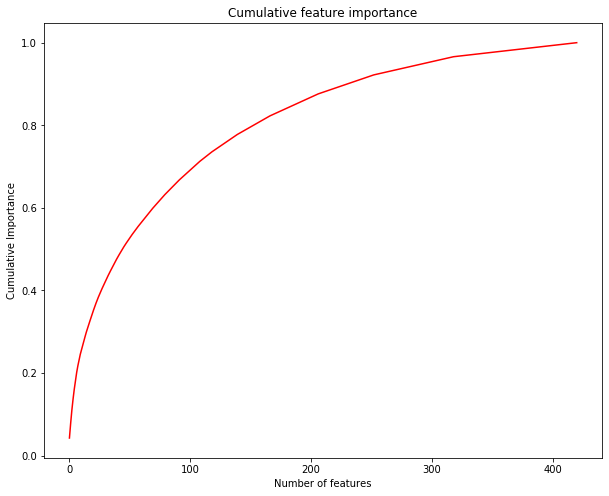

In [82]:
plt.figure(figsize = (10,8))
plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
plt.xlabel('Number of features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative feature importance')
plt.show();

In [83]:
threshold = 0.95

imp_index = np.min(np.where(df['cumulative_importance'] > threshold))
print('{} features required for {} of cumulative importance'.format(imp_index + 1, threshold))

295 features required for 0.95 of cumulative importance


We can keep just `295` features instead of `421` and preserve 95% of the efficiency of the model !

Let's do this selection :

In [85]:
features_to_keep = list(df[df['cumulative_importance'] > threshold]['features'])

train = pd.DataFrame(train, columns = columns)
test = pd.DataFrame(test, columns = columns1)

train_f = train.drop(features_to_keep, axis = 1)
test_f = test.drop(features_to_keep, axis = 1)

print(train_f.shape)
print(test_f.shape)

(307511, 294)
(48744, 294)


In [86]:
imputer = SimpleImputer(strategy = 'median')

train_fi = imputer.fit_transform(train_f)
test_fi = imputer.transform(test_f)

In [226]:
def score(X, y, cv):
    model = LGBMClassifier()
    
    scores = cross_validate(model, X, y, cv = cv, scoring = 'roc_auc', return_train_score = True)
    
   
    return pd.DataFrame(scores)

In [231]:
score(train_fi, tr_labels, cv = 3)

,fit_time,score_time,test_score,train_score
0,11.010009,0.320144,0.775573,0.835390
1,14.668046,0.390533,0.774632,0.835608
2,14.880344,0.304367,0.778190,0.835307


In [232]:

def submission(train, y, test):
    
    
        y = y
        X_train = train
        X_test = test

    
        LGBM = LGBMClassifier().fit(X_train, y)

        # Make predictions on the test data
        predictions = LGBM.predict_proba(X_test)[:, 1]

        LGBM = pd.DataFrame()
        LGBM['SK_ID_CURR'] = test_ids
        LGBM['TARGET'] = predictions
        LGBM.to_csv("LGBM.csv", index=False)

In [233]:
submission(train_fi, tr_labels, test_fi)

`0.77304` with only 294 variables instead of `0.77343` with 414, that's the beauty of features selection, reduce sometimes drastically the number of features and hence the model runtime for slight loss on the model performances. Il would say not a loss at all sometimes

As we can see, we employed a number of feature selection methods. These methods are necessary to reduce the number of features to increase model interpretability, decrease model runtime, and increase generalization performance on the test set.

Using the first three methods (correlation/missing values/features importances), we reduced the number of features from 1465 to 421 with a public leaderboard score of `0.77343`.

After applying the last method ( keep only enough features to account for 95% of the importance), we end up with 294 features with a public leaderboard score of `0.77304`.

<a id="5"></a> <br>
## Hyperparameter Tuning

Hyperparameters can be thought of as model settings. These settings need to be tuned for each problem because the best model hyperparameters for one particular dataset will not be the best across all datasets.


There are several approaches to hyperparameter tuning

- Manual: select hyperparameters based on intuition/experience/guessing.

- Grid Search: set up a grid of hyperparameter values and for each combination.

- Random search: set up a grid of hyperparameter values and select random combinations to train the model and score.

- Automated Hyperparameter Tuning: use methods such as gradient descent, Bayesian Optimization, or evolutionary algorithms to conduct a guided search for the best hyperparameters.


It is difficult to know which combination of hyperparameters will work best based only on theory because there are complex interactions between hyperparameters. Hence the need for hyperparameter tuning: the only way to find the optimal hyperparameter values is to try many different combinations on a dataset !

Here, we will work with a subset of the data consisting of 10000 rows. Hyperparameter tuning is extremely computationally expensive and working with the full dataset in a Kaggle Kernel would not be feasible for more than a few search iterations. However, the same ideas that we will implement here can be applied to the full dataset and while in this section, this is specifically aimed at the Light GBM, the methods can be applied for any machine learning model.

In [3]:
import lightgbm as lgb

Let's import application_train :

In [4]:
N_FOLDS = 5
MAX_EVALS = 5

train = pd.read_csv('application_train.csv')

# Sample 16000 rows (10000 for training, 6000 for testing)
train = train.sample(n = 16000, random_state = 42)

# Only numeric features
train = train.select_dtypes('number')

# Extract the labels
y = np.array(train['TARGET'].astype(np.int32)).reshape((-1, ))
X = train.drop(columns = ['TARGET', 'SK_ID_CURR'])

# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 6000, random_state = 50)

We will also use only the numeric features to reduce the number of dimensions which will help speed up the hyperparameter search. Again, this is something we would not want to do on a real problem, but for demonstration purposes, it will allow us to see the concepts way more faster. No need to lose hours in runtime just for enhanced my skills. That's not the purpose.

In [237]:
print('Training data shape :', X_train.shape)
print('Testing data shape :', X_test.shape)

Training data shape : (10000, 104)
Testing data shape : (6000, 104)


Again we will use Cross-Validation and ROC AUC metric. Part of the reason why hyperparameter tuning is so time-consuming is because of the use of cross validation. We need to use n folds cross validation, which means training and testing the model with each set of hyperparameter values n times to assess performance. Cross validation is a nice method to avoid overfitting.

To implement KFold cross validation, we will use the LightGBM cross validation function `cv`, because this allows us to use a critical technique for training a Gradient Boosting Machine, early stopping. (For other machine learning models where we do not need to use early stopping, we can use the Scikit-Learn functions).

To use the `cv` function, we first need to make a LightGBM dataset.

In [5]:
train_set = lgb.Dataset(data = X_train, label = y_train)
test_set = lgb.Dataset(data = X_test, label = y_test)

In [6]:
model = lgb.LGBMClassifier()
default_params = model.get_params()

del default_params['n_estimators']

cv_results = lgb.cv(default_params, train_set, num_boost_round = 10000,
                    nfold = N_FOLDS, early_stopping_rounds = 100, metrics = 'auc', seed = 42)

The cv_results is a dictionary with lists for the metric mean and the metric standard deviation. The last entry (index of -1) contains the best performing score. The length of each list in the dictionary will be the "optimal" number of estimators to train.

In [9]:
print('The maximum validation ROC AUC was: {:.5f} with a standard deviation of {:.5f}.'.format(cv_results['auc-mean'][-1], cv_results['auc-stdv'][-1]))
print('The optimal number of boosting rounds (estimators) was {}.'.format(len(cv_results['auc-mean'])))

The maximum validation ROC AUC was: 0.70058 with a standard deviation of 0.02819.
The optimal number of boosting rounds (estimators) was 23.


To find out how well the model does on our "test" data, we will retrain it on all the training data with the best number of estimators found during cross validation with early stopping.

In [11]:
from sklearn.metrics import roc_auc_score

# Optimal number of esimators found in cv
model.n_estimators = len(cv_results['auc-mean'])

# Train and make predicions with model
model.fit(X_train, y_train)
preds = model.predict_proba(X_test)[:, 1]
baseline_auc = roc_auc_score(y_test, preds)

print('The baseline model scores {:.5f} ROC AUC on the test set.'.format(baseline_auc))

The baseline model scores 0.72832 ROC AUC on the test set.


This is the baseline score before hyperparameter tuning. The only difference we made from the default model was using early stopping to set the number of estimators (which by default is 100). Let's dive more in depth to see how it goes :

**Hyperparameter Tuning Implementation**

Now we have the basic framework in place: we will use cross validation to determine the performance of model hyperparameters and early stopping with the GBM so we do not have to tune the number of estimators. 

Let's first define our objective function, The objective function takes in hyperparameters and outputs a value representing a score. Traditionally in optimization, this is a score to minimize, but here our score will be the ROC AUC which of course we want to maximize.

In [12]:
def objective(hyperparameters, iteration):
    """Objective function for grid and random search. Returns
       the cross validation score from a set of hyperparameters."""
    
    # Number of estimators will be found using early stopping
    if 'n_estimators' in hyperparameters.keys():
        del hyperparameters['n_estimators']
    
     # Perform n_folds cross validation
    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 42)
    
    # results to retun
    score = cv_results['auc-mean'][-1]
    estimators = len(cv_results['auc-mean'])
    hyperparameters['n_estimators'] = estimators 
    
    return [score, hyperparameters, iteration]

Let's define our parameters grid, to see which one we can configure, let's first see the Light GBM parameters :

In [98]:
model = lgb.LGBMModel()
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

Let's pick up some of the most important paramaters (I made my choice by looking at others kernels) and create our grid.

Choosing a hyperparameter grid is probably the most difficult part of hyperparameter tuning: it's nearly impossible ahead of time to say which values of hyperparameters will work well and the optimal settings will depend on the dataset. That's why I inspired myself with others experimented fellow Data Scientist. 

A complete grid for the 10 hyperparameter is defined below. Each of the values in the dicionary must be a list, so we use list combined with range, np.linspace, and np.logspace to define the range of values for each hyperparameter.

In [109]:
param_grid = {
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(20, 150)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'is_unbalance': [True, False]
}


One aspect to note is that if boosting_type is goss, then we cannot use subsample. We will need to deal with that. Let's keep it for later. For now we will see the distribution we attributed in our grid for the parameter `learning_rate`.

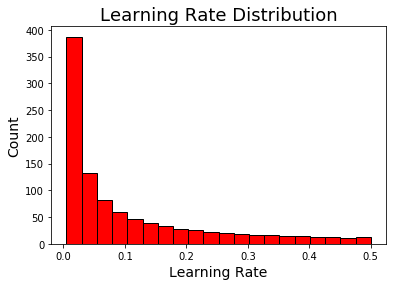

In [20]:
# Learning rate histogram
plt.hist(param_grid['learning_rate'], bins = 20, color = 'r', edgecolor = 'k');
plt.xlabel('Learning Rate', size = 14)
plt.ylabel('Count', size = 14)
plt.title('Learning Rate Distribution', size = 18);

The learning rate domain is from 0.005 to 0.5. Using a logarithmic uniform distribution allows us to create a domain where there are as many values from 0.005 to 0.05 as from 0.05 to 0.5. 

Now let's implement how to keep tracks on our tuning search results history. A dataframe is a useful data structure to hold the results. So let's do this.

In [21]:
random_results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))

grid_results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))

**Grid Search Implementation**

Grid search suffers from one limiting problem: it is extremely computationally expensive because we have to perform cross validation with every single combination of hyperparameters in the grid! Let's see how many total hyperparameter settings there are in our simple little grid we developed.

In [22]:
com = 1
for x in param_grid.values():
    com *= len(x)
print('There are {} combinations'.format(com))

There are 2620800000000000 combinations


Too long, we need to create a function to make our tuning way faster.

We can see the lines `hyperparameters['subsample'] = 1.0 if hyperparameters['boosting_type'] == 'goss' else hyperparameters['subsample']` who fix the problem we mentionned earlier.

In [23]:
import itertools

def grid_search(param_grid, max_evals = MAX_EVALS):
    """Grid search algorithm (with limit on max evals)"""
    
    # Dataframe to store results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))
    
    # https://codereview.stackexchange.com/questions/171173/list-all-possible-permutations-from-a-python-dictionary-of-lists
    keys, values = zip(*param_grid.items())
    
    i = 0
    
    # Iterate through every possible combination of hyperparameters
    for v in itertools.product(*values):
        
        # Create a hyperparameter dictionary
        hyperparameters = dict(zip(keys, v))
        
        # Set the subsample ratio accounting for boosting type
        hyperparameters['subsample'] = 1.0 if hyperparameters['boosting_type'] == 'goss' else hyperparameters['subsample']
        
        # Evalute the hyperparameters
        eval_results = objective(hyperparameters, i)
        
        results.loc[i, :] = eval_results
        
        i += 1
        
        # Normally would not limit iterations
        if i > MAX_EVALS:
            break
       
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    
    return results    

Let me explain all of that before we continue.

The code above shows the "algorithm" for grid search :

- First, we unpack the values in the hyperparameter grid (which is a Python dictionary) using the `line keys, values = zip(*param_grid.items())`.


- The key line is for `v in itertools.product(*values)` where we iterate through all the possible combinations of values in the hyperparameter grid one at a time.


- For each combination of values, we create a dictionary `hyperparameters = dict(zip(keys, v))` and then pass these to the objective function defined earlier.


- The objective function returns the cross validation score from the hyperparameters which we record in the dataframe.


- This process is repeated for each and every combination of hyperparameter values. 


By using `itertools.product`  we create a generator rather than allocating a list of all possible combinations which would be far too large to hold in memory.

Also, the real grid search function do not use 

`if i > MAX_EVALS:
 break            `
 
These lines aim to reduce the runtime.

In [43]:
%%time 

grid_results = grid_search(param_grid)

print('The best validation score was {:.5f}'.format(grid_results.loc[0, 'score']))
print('\nThe best hyperparameters were:')

import pprint
pprint.pprint(grid_results.loc[0, 'params'])

The best validation score was 0.72038

The best hyperparameters were:
{'boosting_type': 'gbdt',
 'colsample_bytree': 0.6,
 'is_unbalance': True,
 'learning_rate': 0.004999999999999999,
 'min_child_samples': 20,
 'n_estimators': 850,
 'num_leaves': 20,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 0.5,
 'subsample_for_bin': 20000}
Wall time: 1min 37s


We can see that the runtime was extremely fast (less than 2 minutes) and we obtained quite a nice results, so if we don't have the time to run real Grid Search CV and still do some tuning, this is a good alternative.

Now, since we have the best hyperparameters, we can evaluate them on our "test" data (remember not the real test data)!

In [32]:
# Get the best parameters
grid_search_params = grid_results.loc[0, 'params']

# Create, train, test model
model = lgb.LGBMClassifier(**grid_search_params, random_state=42)
model.fit(X_train, y_train)

preds = model.predict_proba(X_test)[:, 1]

print('The best model from grid search scores {:.5f} ROC AUC on the test set.'.format(roc_auc_score(y_test, preds)))

The best model from grid search scores 0.73334 ROC AUC on the test set.


It's interesting that the model scores better on the test set than in cross validation. Usually the opposite happens (higher on cross validation than on test). Let's try another tuning methods.

**Random Search Implementation**

Let's define the function.

This takes the same general structure as grid_search except for the method used to select the next hyperparameter values. Moreover, random search is always run with a limit on the number of search iterations.

In [41]:
import random

random.seed(50)

def random_search(param_grid, max_evals = MAX_EVALS):
    """Random search for hyperparameter optimization"""
    
    # Dataframe for results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                                  index = list(range(MAX_EVALS)))
    
    # Keep searching until reach max evaluations
    for i in range(MAX_EVALS):
        
        # Choose random hyperparameters
        hyperparameters = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
        hyperparameters['subsample'] = 1.0 if hyperparameters['boosting_type'] == 'goss' else hyperparameters['subsample']

        # Evaluate randomly selected hyperparameters
        eval_results = objective(hyperparameters, i)
        
        results.loc[i, :] = eval_results
    
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    return results 

In [42]:
%%time

random_results = random_search(param_grid)

print('The best validation score was {:.5f}'.format(random_results.loc[0, 'score']))
print('\nThe best hyperparameters were:')

import pprint
pprint.pprint(random_results.loc[0, 'params'])

The best validation score was 0.71990

The best hyperparameters were:
{'boosting_type': 'gbdt',
 'colsample_bytree': 0.6444444444444444,
 'is_unbalance': False,
 'learning_rate': 0.08633904519421778,
 'min_child_samples': 290,
 'n_estimators': 30,
 'num_leaves': 104,
 'reg_alpha': 0.8163265306122448,
 'reg_lambda': 0.1020408163265306,
 'subsample': 0.9444444444444444,
 'subsample_for_bin': 200000}
Wall time: 10min 53s


Here it take way more time than grid_search. But that's remains quite faster. Let's see how it does with the test set.

In [45]:
# Get the best parameters
random_search_params = random_results.loc[0, 'params']

# Create, train, test model
model = lgb.LGBMClassifier(**random_search_params, random_state=42)
model.fit(X_train, y_train)

preds = model.predict_proba(X_test)[:, 1]

print('The best model from grid search scores {:.5f} ROC AUC on the test set.'.format(roc_auc_score(y_test, preds)))

The best model from grid search scores 0.73697 ROC AUC on the test set.


So let's see if this tuning work well with the Kaggle's score submission.

<a id="6"></a> <br>
## Final submission to Kaggle

Let's try to submit to Kaggle with all of our data (feature engineered and so on) after feature selection in order to decrese computer runtime and see if we can improve our last Kaggle's ROC AUC score with :

 - The tuned hyperparameters found with GridSearch 
 
 - The tuned hyperparameters found with Random Search
 
 
**Functions and hyperparameters**

In [89]:
print('Final Training Shape :',train_fi.shape)
print('Final Testing Shape :',test_fi.shape)

Final Training Shape : (307511, 294)
Final Testing Shape : (48744, 294)


In [92]:
print('The hyperparameters found with Grid Search :')
print(grid_search_params)

The hyperparameters found with Grid Search :
{'boosting_type': 'gbdt', 'num_leaves': 20, 'learning_rate': 0.004999999999999999, 'subsample_for_bin': 20000, 'min_child_samples': 20, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'colsample_bytree': 0.6, 'subsample': 0.5, 'is_unbalance': True, 'n_estimators': 850}


In [93]:
print('The hyperparameters found with Random Search :')
print(random_search_params)

The hyperparameters found with Random Search :
{'boosting_type': 'gbdt', 'num_leaves': 104, 'learning_rate': 0.08633904519421778, 'subsample_for_bin': 200000, 'min_child_samples': 290, 'reg_alpha': 0.8163265306122448, 'reg_lambda': 0.1020408163265306, 'colsample_bytree': 0.6444444444444444, 'subsample': 0.9444444444444444, 'is_unbalance': False, 'n_estimators': 30}


In [90]:
def score(X, y, cv, params):
    model = LGBMClassifier(**params, random_state=42)
    
    scores = cross_validate(model, X, y, cv = cv, scoring = 'roc_auc', return_train_score = True)
    
    return pd.DataFrame(scores)



def submission(train, y, test, params):
        
        y = y
        X_train = train
        X_test = test

    
        LGBM = LGBMClassifier(**params, random_state = 42).fit(X_train, y)

        # Make predictions on the test data
        predictions = LGBM.predict_proba(X_test)[:, 1]

        LGBM = pd.DataFrame()
        LGBM['SK_ID_CURR'] = test_ids
        LGBM['TARGET'] = predictions
        LGBM.to_csv("LGBM.csv", index=False)

**The tuned hyperparameters found with GridSearch**

In [94]:
score(train_fi, tr_labels, 3, grid_search_params)

,fit_time,score_time,test_score,train_score
0,102.590567,1.422196,0.770321,0.790411
1,50.014232,1.565813,0.766182,0.791104
2,51.122300,1.537887,0.771820,0.789598


In [95]:
submission(train_fi, tr_labels, test_fi, grid_search_params)

`0.76263` Slightly worse than without the hyperparameter tuning

**The tuned hyperparameters found with RandomSearch**

In [96]:
score(train_fi, tr_labels, 3, random_search_params)

,fit_time,score_time,test_score,train_score
0,8.867282,0.348070,0.768317,0.820333
1,8.493284,0.363026,0.762812,0.820182
2,9.727982,0.390954,0.768992,0.819016


It's looklike this model with this kind of hyperparameters tends to overfit. We can see a AUC difference by 0.4 between the test score and the train score.

In [97]:
submission(train_fi, tr_labels, test_fi, random_search_params)

`0.76290`, same here. Even more overfitting, because the cross validation is around 0,82 for the train score and 0,76 for the test score. That's the problem sometimes with hyperparameters tuning, they can improve your perfomances but also be too much specific and overfit, at least we tried.

It should also be noted than our tuning was made on a sample of our data. We took juste `application` and not all the others data like `bureau`, `bureau_balance` and so on. It would have taken forever to run our tuning function on all the data and I think it's not worthwile, this part aim to train and experiment, not perfection. So maybe it explains why the tuning hyperparameters found are not THAT good with the Kaggle's scores. They were trained on a subsample.

<a id="7"></a> <br>
## Conclusion

So after all that work, what could we conclude ? We implemented many methods like :

 - Polynomial Features
 - Domain Features
 - Manual features engineering
 - Automated features engineering
 - Feature selection
 - Tuning hyperparameters.
 
We have seen than add feature in an intelligent way, and not in an arbitrary way results frequently with enhance result, that's obvious.
But we also see that having too many variable is not always optimal. Sometimes if we use the right feature selection methods, we can drastically reduce the number of variables and lose almost no performances. Even better, the model tend to less overfit with less variables, so it's just a matter of find the right spot within the time you have at your disposal. 
We have also seen that tuning hyperparameters can sometimes lead to weaker results due to overfitting. That's obviously not always the case, sometimes tuning it's a great tools to capture the spirit of the data, but not always. So be cautious, use the tuning if you have the time and the computer because it's computationnaly expensive and it's not always profitable.

So that's wrap up my work with Home Credit, hope you enjoyed it. See you in my next work !